In [1]:
import jax
import jax.numpy as jnp
from jax.random import key, split, uniform

import numpy as np

import matplotlib.pyplot as plt

from baum_welch_jax.algorithms import baum_welch, generate_sequence
from baum_welch_jax.models import HiddenMarkovParameters

from plotting import plot_hmm_params, plot_inference_statistics, plot_stats


jax.config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=3)

# Example for HMM inference using Baum Welch

This notebook shows how to construct a Hidden markov model, generate sequences from it and how to infer the parameters from observation sequences. 

It illustrates how sometimes the model is not uniquely identifyable, and restricting the initial guesses can help convergence.

First we define a model.

In [2]:
seed = 2345
n = 4 # Number of states
m = 3 # Number of observations

# Construct a transition matrix that stays in the same state with 99% probability 
# and transitions to the next with 1%. The last state loops back into the first
T = 0.95 * jnp.eye(n, dtype=jnp.float64)
T = T + 0.05 * jnp.eye(n, k=1)
T = T.at[-1, 0].set(0.05)

# Normalize
T = T / jnp.sum(T, axis=-1)[:,None]

# Construct an initial state distribution where the earlier states are more likely
mu = jnp.exp(-jnp.linspace(0, 10, n, dtype=jnp.float64))
mu = mu.at[n -1].set(0)

# Normalize
mu = mu / jnp.sum(mu)

# Construct a noisy observation matrix, this looks a bit complicated
O = jnp.eye(n, m) + jnp.eye(n, m, 1) * 0.4 + jnp.eye(n, m, -1) * 0.7 + jnp.eye(n, m, -2) * 0.1
O = O.at[-1, :-1].set(0.0)
O = O.at[0, 1:].set(0.0)
O = O / jnp.sum(O, axis=-1)[:,None]

hmm = HiddenMarkovParameters(T, O, mu)

print("T row sums:", jnp.sum(T, axis=-1), 
      "\nO row sums:", jnp.sum(O, axis=-1), 
      "\nmu sum:", jnp.sum(mu)[None])


T row sums: [1. 1. 1. 1.] 
O row sums: [1. 1. 1. 1.] 
mu sum: [1.]


Let us inspect the model parameters as matrix plots.

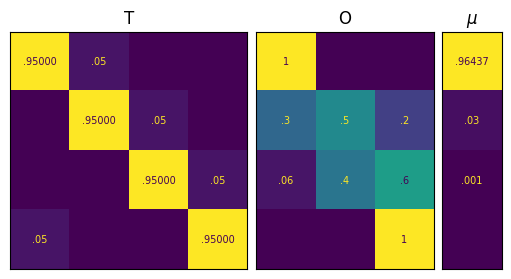

In [3]:
fig, ax = plot_hmm_params(hmm, with_numbers=True)
fig.set_size_inches(5,3)
plt.show()

Let us generate some sequences from this process.

In [4]:
n_sequences = 20
len_sequence = 500

rng_key, sequence_key = split(key(123))

# To generate multiple sequences, either pass multiple initial state distributions like here
# Or alternatively vmap over the desired amount of sequence keys!
mu_seq = jnp.concat(jnp.eye(n)[None, ...].repeat(n_sequences // n, axis=0))

states, observations = generate_sequence(sequence_key, hmm.replace_mu(mu_seq), len_sequence)

print("states.shape =", states.shape)

states.shape = (20, 500)


We are now ready to learn form the sequences. Therefore, we initialize the HMM and then run the Baum-Welch algorithm.

In [5]:
key_T, key_O, key_mu = split(key(0), 3)

_T = uniform(key_T, T.shape)
_O = uniform(key_O, O.shape)
_mu = uniform(key_mu, mu.shape)


_T = _T / jnp.sum(_T, axis=1)[:, None]
_O = _O / jnp.sum(_O, axis=1)[:, None]
_mu = _mu / jnp.sum(_mu)


init_guess = HiddenMarkovParameters(_T, _O, _mu)
result = baum_welch(observations, init_guess)

print('Iterations:', result.iterations)

Iterations: 100


Let's check the convergence statistics to see if we are actually converged:

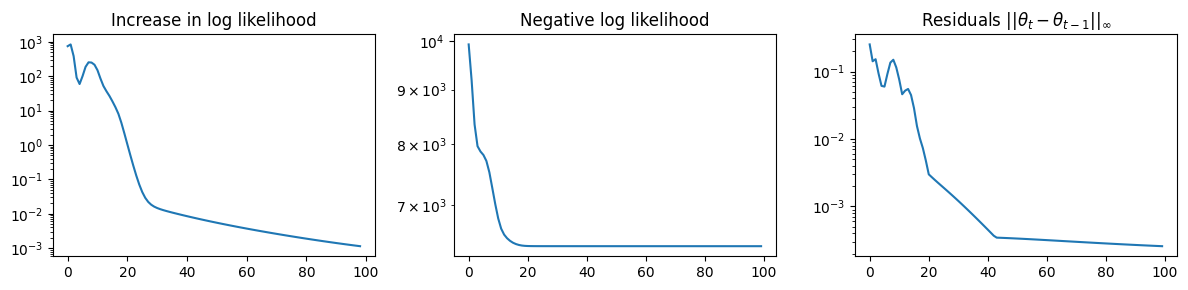

T =
[[7.130e-01 6.932e-04 9.243e-03 2.771e-01]
 [2.321e-02 9.718e-01 3.788e-04 4.566e-03]
 [3.269e-46 5.341e-02 9.466e-01 2.038e-46]
 [5.138e-01 1.495e-03 1.253e-01 3.594e-01]]

O =
[[5.442e-07 2.053e-03 9.979e-01]
 [1.893e-01 4.483e-01 3.624e-01]
 [1.000e+00 1.319e-21 9.180e-49]
 [1.524e-03 3.739e-08 9.985e-01]]

mu=
[2.054e-01 5.205e-01 2.742e-01 5.069e-06]


In [6]:
plot_inference_statistics(result)
plt.show()

print(result.params.to_prob())

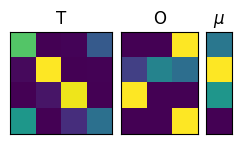

Likelihood is nondecreasing: True


In [7]:
fig, ax = plot_hmm_params(result.params)
plt.show()

print('Likelihood is nondecreasing:', bool(jnp.all(jnp.diff(result.log_likelihoods[:result.iterations]) >= 0)))

The result does not seem quite right. In fact, there are often multiple parameters sets that might explain our data well. Depending on the initialization, the algorithm might find different local maxima. However, since we assume our model to have some structure, we can impose this in the initial guess. 

Any probabilities which are 0 in the initial guess can never be elevated to a value above 0. This is a property of the algorithm, let us use it to our advantage.

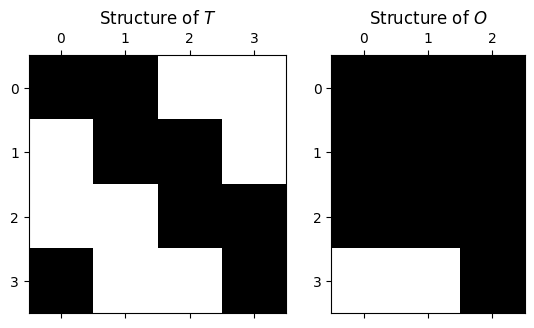

In [8]:
T_structure = jnp.tril(jnp.triu(jnp.ones_like(T, dtype=jnp.float64)), 1)
T_structure = T_structure.at[-1, 0].set(1.0)
O_structure = jnp.ones_like(O, dtype=jnp.float64)
O_structure = O_structure.at[n-1, :m-1].set(0)

fig, ax = plt.subplots(1,2, width_ratios=(n, m))
ax[0].spy(T_structure)
ax[0].set_title("Structure of $T$")
ax[1].spy(O_structure)
ax[1].set_title("Structure of $O$")
plt.show()

We now start from a more informed initial guess:

In [9]:
key_T, key_O, key_mu = split(key(120), 3)

# Some additional hints to the correct structure
_T = uniform(key_T, T.shape) * T_structure + jnp.eye(n)
_O = uniform(key_O, O.shape) * O_structure + jnp.eye(n, m)
_mu = uniform(key_mu, mu.shape) + jnp.array([k == 0 for k in range(n)])


_T = _T / jnp.sum(_T, axis=1)[:, None]
_O = _O / jnp.sum(_O, axis=1)[:, None]
_mu = _mu / jnp.sum(_mu)
init_guess = HiddenMarkovParameters(_T, _O, _mu)



In [10]:
result = baum_welch(observations, init_guess, max_iter=300)

/home/tobias/Projects/StochasticProcessInference/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1518: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


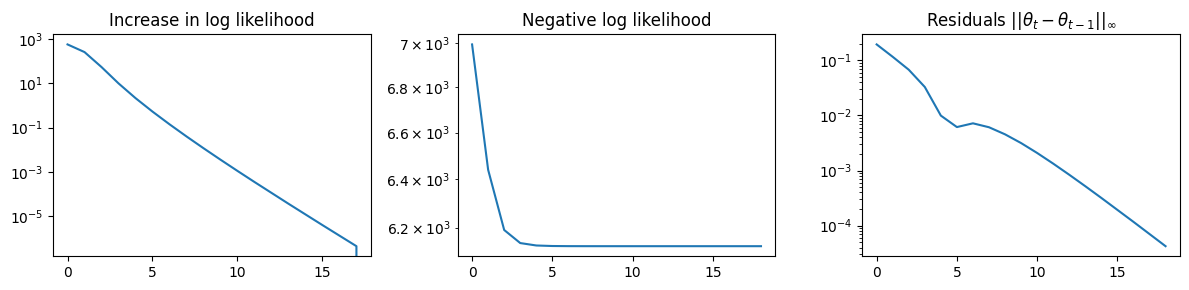

Iterations: 19
T =
[[0.946 0.054 0.    0.   ]
 [0.    0.947 0.053 0.   ]
 [0.    0.    0.948 0.052]
 [0.048 0.    0.    0.952]]

O =
[[1.000e+00 6.394e-14 3.332e-11]
 [3.228e-01 4.787e-01 1.986e-01]
 [6.175e-02 3.909e-01 5.473e-01]
 [0.000e+00 0.000e+00 1.000e+00]]

mu=
[0.274 0.205 0.323 0.198]


In [11]:
plot_inference_statistics(result)
plt.show()

print('Iterations:', result.iterations)
print(result.params.to_prob())

The parameters look rather close upon first inspection.

Estimated parameters:


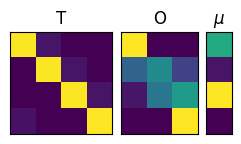

Original parameters:


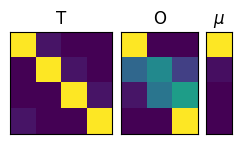

In [12]:
print('Estimated parameters:')
fig, ax = plot_hmm_params(result.params)
plt.show()

print('Original parameters:')
fig, ax = plot_hmm_params(hmm)
plt.show()


We can look into the differences between the ground truth and the estimated parameters to get a better picture:

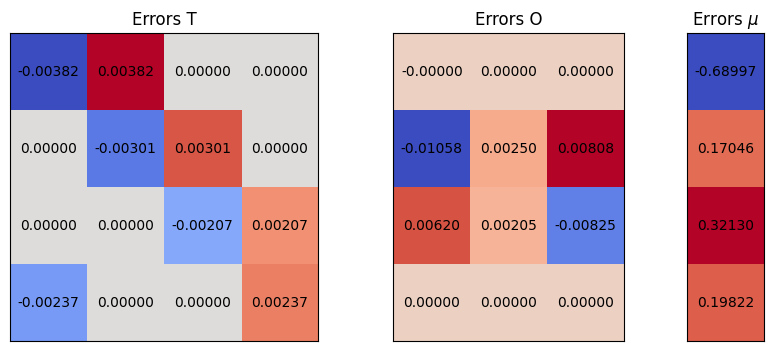

In [13]:
fig, ax = plt.subplots(1, 3, width_ratios=(n, m, 1))
fig.set_size_inches(10,4)

res_hmm = result.params.to_prob()

errors = [
    res_hmm.T - T,
    res_hmm.O - O,
    res_hmm.mu[:,None] - mu[:,None]
]

labels = [
    'T',
    'O',
    '$\\mu$'
]

for k, (err_mat, label) in enumerate(zip(errors, labels)):
    ax[k].matshow(err_mat, cmap='coolwarm')
    for (i, j), z in np.ndenumerate(err_mat):
        ax[k].text(j, i, '{:0.5f}'.format(z), ha='center', va='center')
    ax[k].set_title(f"Errors {label}")
    ax[k].set_xticks([])
    ax[k].set_yticks([])
plt.show()

Finally, let us compare the model outputs. Below the true model is compared to the estimated model in terms of hidden state evolution and observations:

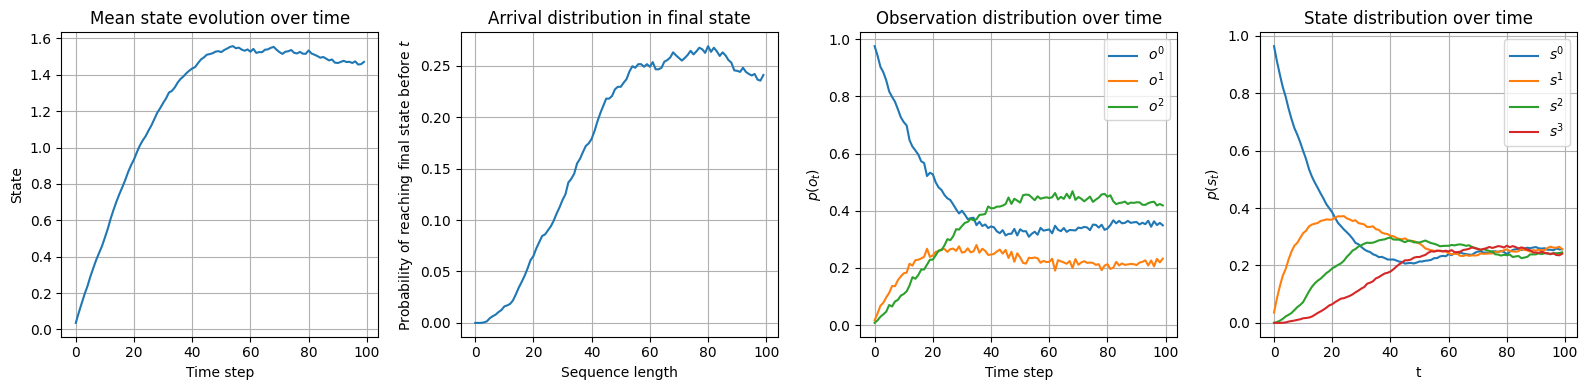

In [14]:
n_sequences = 2000
len_sequence = 100
seed = 512

rng_key, *sequence_keys = split(key(seed), 1 + n_sequences)

generate = jax.jit(lambda _key: generate_sequence(_key, hmm, len_sequence))

states, observations = jax.vmap(generate)(jnp.array(sequence_keys))

plot_stats(states, observations)

We start the estimated model from the same state as our true model:

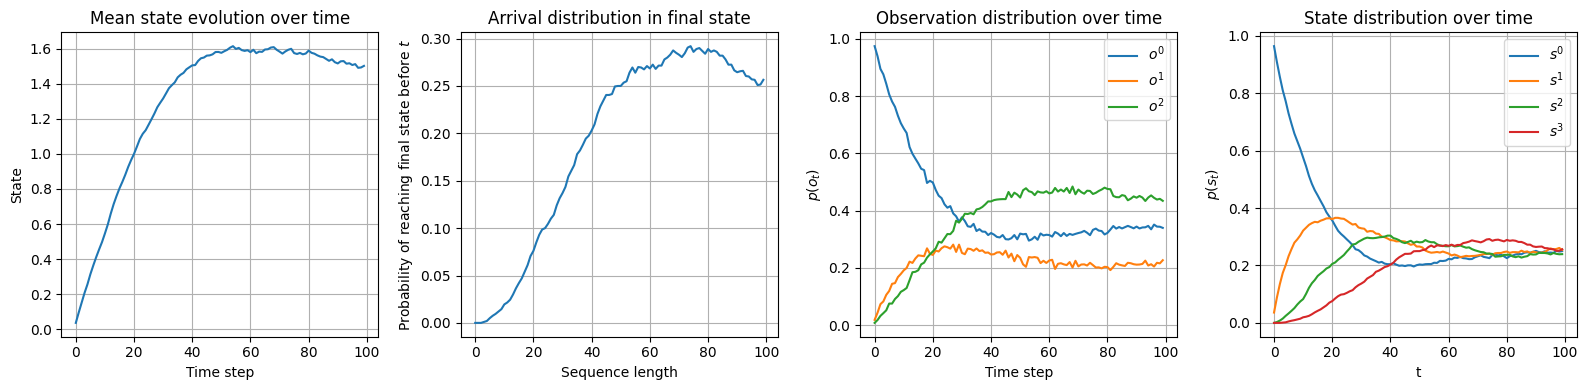

In [15]:
generate = jax.jit(lambda _key: generate_sequence(_key, res_hmm.replace_mu(hmm.mu), len_sequence))

states, observations = jax.vmap(generate)(jnp.array(sequence_keys))

plot_stats(states, observations)